In [18]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from latex import latexify, format_axes
from pprint import pprint

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [19]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

mps


In [20]:
!wget https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv -O names-long.csv

--2024-03-10 15:04:02--  https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85538 (84K) [text/plain]
Saving to: ‘names-long.csv’

names-long.csv      100%[===================>]  83.53K  --.-KB/s    in 0.02s   

2024-03-10 15:04:02 (4.24 MB/s) - ‘names-long.csv’ saved [85538/85538]



In [21]:
!head names-long.csv

,Name
0,aabid
1,aabida
2,aachal
3,aadesh
4,aadil
5,aadish
6,aaditya
7,aaenab
8,aafreen


In [22]:
!tail names-long.csv

6476,zeshan
6477,zhini
6478,ziarul
6479,zile
6480,zina
6481,zishan
6482,ziyabul
6483,zoya
6484,zuhaib
6485,zuveb


In [29]:
words = pd.read_csv("names-long.csv")["Name"]
words = words.str.lower()
words = words.str.strip()
words = words.str.replace(" ", "")

words = words[words.str.len() > 2]
words = words[words.str.len() < 10]

words = words.sample(frac = 1).reset_index(drop = True)
words = words.tolist()

words = [word for word in words if word.isalpha()]
words[:10]

['joyate',
 'chanpa',
 'vanshu',
 'nafisa',
 'begraj',
 'manesh',
 'harpal',
 'gangajali',
 'ishwer',
 'durga']

In [30]:
len(words)

6184

In [31]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
pprint(itos)

{0: '.',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}


In [32]:
block_size = 6 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

...... ---> j
.....j ---> o
....jo ---> y
...joy ---> a
..joya ---> t
.joyat ---> e
joyate ---> .
...... ---> c
.....c ---> h
....ch ---> a
...cha ---> n
..chan ---> p
.chanp ---> a
chanpa ---> .
...... ---> v
.....v ---> a
....va ---> n
...van ---> s
..vans ---> h
.vansh ---> u
vanshu ---> .
...... ---> n
.....n ---> a
....na ---> f
...naf ---> i
..nafi ---> s
.nafis ---> a
nafisa ---> .
...... ---> b
.....b ---> e
....be ---> g
...beg ---> r
..begr ---> a
.begra ---> j
begraj ---> .
...... ---> m
.....m ---> a
....ma ---> n
...man ---> e
..mane ---> s
.manes ---> h
manesh ---> .
...... ---> h
.....h ---> a
....ha ---> r
...har ---> p
..harp ---> a
.harpa ---> l
harpal ---> .
...... ---> g
.....g ---> a
....ga ---> n
...gan ---> g
..gang ---> a
.ganga ---> j
gangaj ---> a
angaja ---> l
ngajal ---> i
gajali ---> .
...... ---> i
.....i ---> s
....is ---> h
...ish ---> w
..ishw ---> e
.ishwe ---> r
ishwer ---> .
...... ---> d
.....d ---> u
....du ---> r
...dur ---> g
..durg ---> a
.durga

In [33]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([44325, 6]), torch.int64, torch.Size([44325]), torch.int64)

In [34]:
# Embedding layer for the context
emb_dim = 2
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [35]:
emb.weight

Parameter containing:
tensor([[ 0.4467, -0.1521],
        [-1.5122,  1.3747],
        [-1.5828, -0.1645],
        [-1.3247,  1.5094],
        [-0.6552,  0.2684],
        [ 0.3702,  0.6972],
        [-1.5209,  0.9072],
        [-1.3207, -1.0116],
        [ 0.5313, -1.2704],
        [-0.1176, -0.4682],
        [-0.1676,  0.6424],
        [ 0.2199,  0.6795],
        [-0.2577,  1.1204],
        [ 0.5831,  2.3591],
        [ 1.2759, -0.7879],
        [ 0.0234,  0.4617],
        [ 0.5425,  0.9716],
        [ 0.1243,  1.0201],
        [ 0.6541, -0.2934],
        [-0.3801,  0.4222],
        [ 1.6377, -0.1767],
        [-0.1054,  0.5136],
        [ 1.4304, -0.1785],
        [ 0.4663, -0.1879],
        [-0.5254,  2.1931],
        [ 0.4736, -1.0893],
        [-0.2242,  0.4170]], requires_grad=True)

In [36]:
emb.weight.shape

torch.Size([27, 2])

<Axes: >

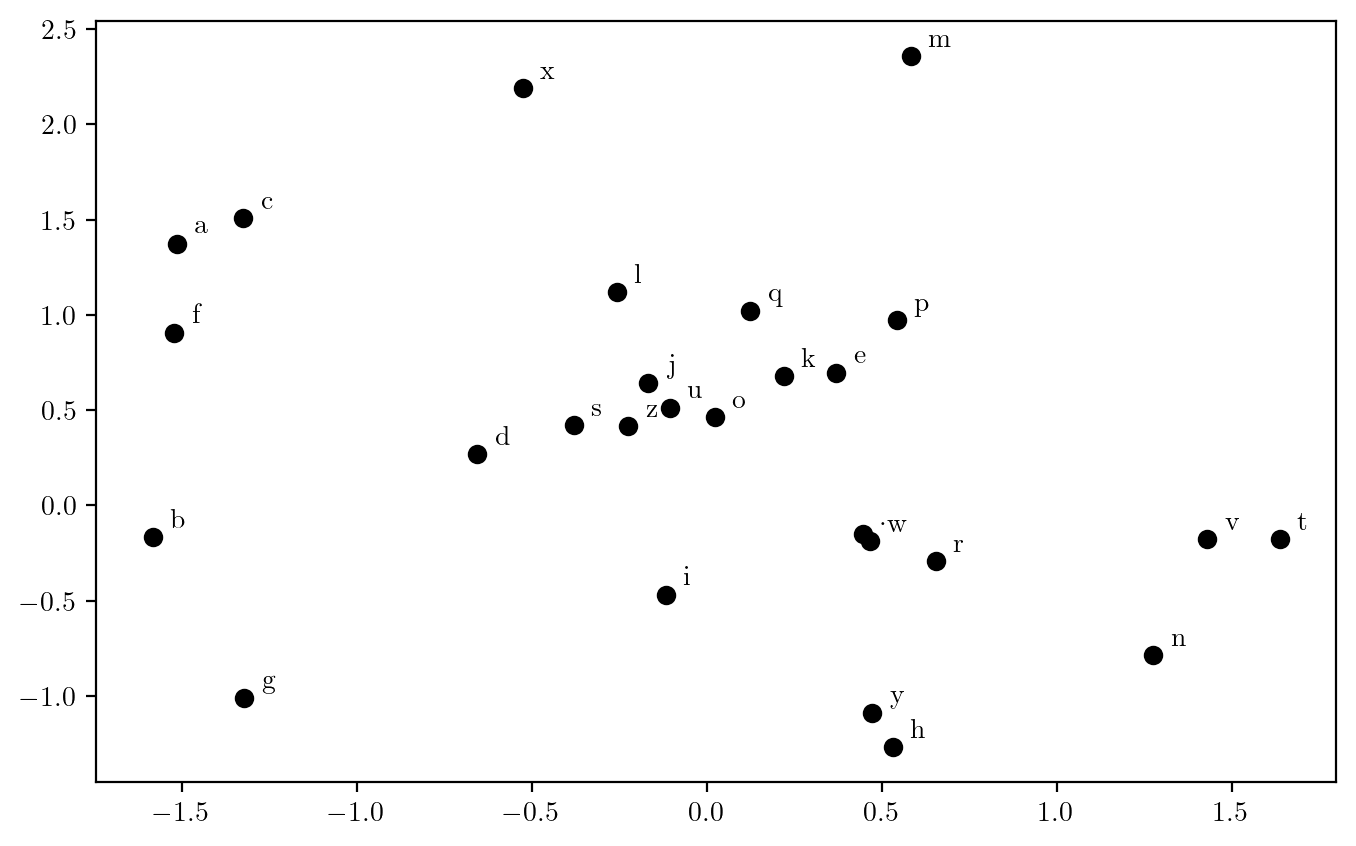

In [39]:
# # Function to visualize the embedding in 2d space
latexify(columns = 2, fig_width = 8)
def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        x, y = emb.weight[i].detach().cpu().numpy()
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

In [16]:
!export LC_ALL="en_US.UTF-8"
!export LD_LIBRARY_PATH="/usr/lib64-nvidia"
!export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
!ldconfig /usr/lib64-nvidia

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link



![](./Embed.png)

In [17]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x))
    x = self.lin2(x)
    return x

In [18]:
# Generate names from untrained model


model = NextChar(block_size, len(stoi), emb_dim, 10).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(400002)
def generate_name(model, itos, stoi, block_size, max_len=10):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits = y_pred).sample().item()
        ch = itos[ix]
        if ch == '.':
            break
        name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

slmtxgxzhd
wlxljwrioe
eed
tlgnyjqltt
yikajavwxr
nmahkaiijq
elcvnwtecg
larf

izobfrwwxi


In [19]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([27, 2])
_orig_mod.lin1.weight torch.Size([10, 12])
_orig_mod.lin1.bias torch.Size([10])
_orig_mod.lin2.weight torch.Size([27, 10])
_orig_mod.lin2.bias torch.Size([27])


In [20]:
# Train the model

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 4096
print_every = 100
elapsed_time = []
for epoch in range(10000):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())


0 3.0310513973236084
100 2.1728384494781494
200 2.162442445755005
300 2.15645432472229
400 2.1538052558898926
500 2.15228271484375
600 2.1485018730163574
700 2.143038034439087


KeyboardInterrupt: 

<Axes: >

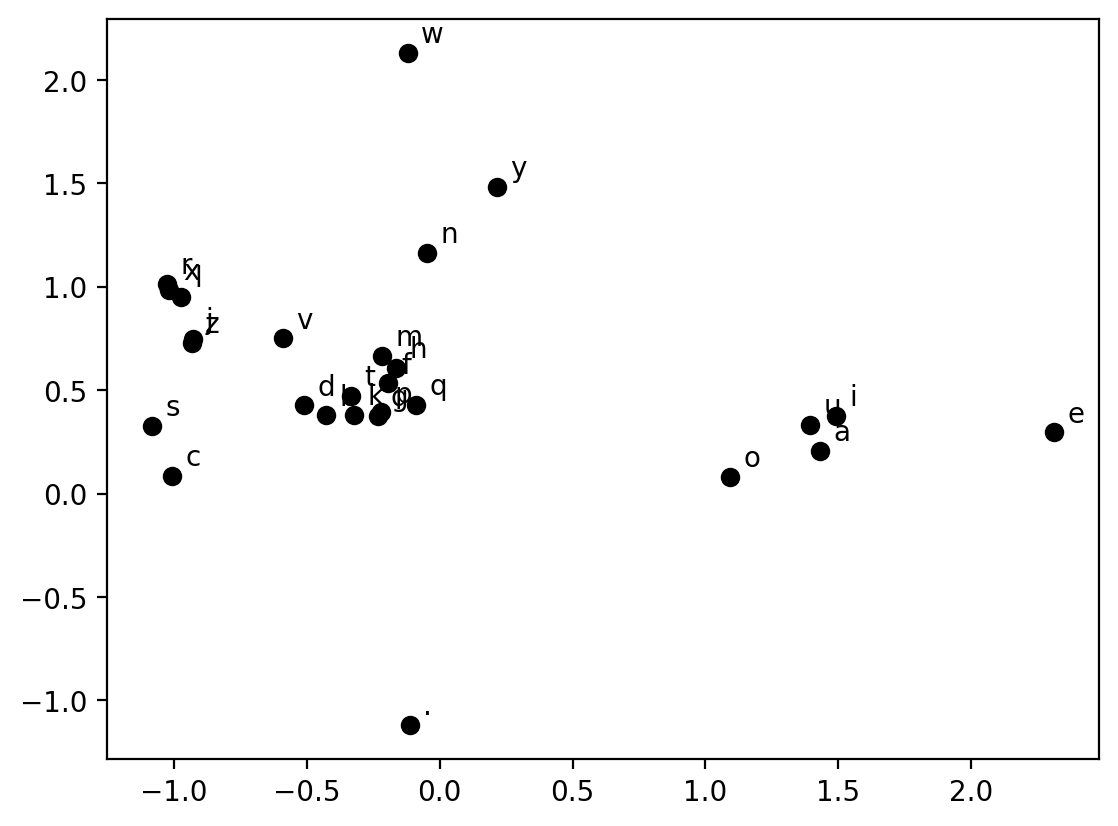

In [21]:
# # Visualize the embedding

plot_emb(model.emb, itos)

In [24]:
# Generate names from trained model

for i in range(50):
    print(generate_name(model, itos, stoi, block_size))

jite
rahevesh
similiyav
taleer
buore
maknom
chedi
grazamendw
cheta
romiran
rpantinshu
sidhra
makeet
asamim
sadir
jakendh
kani
pupnu
soshik
chligad
ajatay
graga
dena
ridhinav
kunkyan
mvitseen
shireder
yajsh
daakik
vichimi
bohain
madinkindu
nichri
lavta
ramun
yara
sevher
bab
parav
garkana
dashir
amehu
afala
vatniya
grafsh
sudees
dyajanar
barni
amlavd
vara


Tuning knobs

1. Embedding size
2. MLP
3. Context length